## Exercise - Loan Agent - STARTER
In this exercise, you’ll build a Loan Agent Workflow using LangGraph, designed to negotiate loan amounts with customers.

Challenge

You’re developing an AI-powered Loan agent.
  
The workflow should:  

Interpret user queries intelligently.  
Dynamically calls tools for loan calculation  
Track negotiation status and terminates gracefully.  
Route the workflow using intelligent conditional edges.  
  
Your agent will calculate the maximum amount a customer can request based on their profile. If it exceeds, it will mark the status as lost and will explain the reason to the customer. If it meets, make as won, and notify the customer a human representative will contact them.

By the end of this exercise, you will have learned:  

Config  
Limiting Messages (RemoveMessages and summary)  
Command (Updating State from a Tool)    
Checkpoints (with thread_id)  
## 0. Import the necessary libs

In [1]:
import re
import uuid
from typing_extensions import Literal, Annotated
from langchain_core.messages import (
    SystemMessage,
    AIMessage,
    HumanMessage, 
    ToolMessage,
    RemoveMessage
)
from langchain_core.tools.base import InjectedToolCallId
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langchain_core.runnables import RunnableConfig
from langgraph.graph.message import MessagesState, add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langgraph.types import Command
from IPython.display import Image, display

1. Instantiate Chat Model with your API Key
To be able to connect with OpenAI, you need to instantiate an ChatOpenAI client passing your OpenAI key.

You can pass the api_key argument directly.

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key="voc-",
)

In [2]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
 #   api_key = "YOUR_API_KEY_HERE", # mine is set in my venv already
)

2. Create the State Schema
Your state should have at least 3 elements:

customer query, the user input to start the conversation
messages, to keep track of the conversation
negotiation status, to determine when to terminate the execution
Feel free to use TypedDict or MessagesState.

In [3]:
# TODO - State Schema called SessionState
class SessionState(MessagesState):
    customer_query: str
    negotiation_status: Literal["won", "lost", "in_progress"]

3. Define your Entrypoint node
This node should have the following responsibilities:

Access all the configuration (RunnableConfig)
Create the SystemMessage to instruct the agent
Limit number of messages for each execution using summary and RemoveMessage
Create the HumanMessage based on the customer_query

In [4]:
# TODO - Define your function to summarize previous messages (used in filtermessages, next cell down)
def summarize_conversation(messages) -> AIMessage:
    messages_to_summarize = messages[1:-1]
    summary_message = HumanMessage(
        content="Create a summary of the conversation above:",
    )
    ai_message = llm.invoke(
        add_messages(
            messages_to_summarise,
            summary_message
        )
    )
    ai_message.id = str(uuid.uuid4())
    return ai_message

In [5]:
# TODO - The entrypoint node
# An initial prompt is already created to help you
def entry_point(state: SessionState, config: RunnableConfig):
    messages = state["messages"]
    customer_name = config.get("configurable", {}).get("customer_name", "customer")
    age = config.get("configurable", {}).get("age", 18)
    income = config.get("configurable", {}).get("income", 1000)
    credit_score = config.get("configurable", {}).get("credit_score", 500)
    if not messages:
        prompt = (
            "You are a Loan Agent analysing a customer loan request.\n"
            "- Understand how much the customer needs.\n"
            "- Calculate the maximum loan amount using one of the provided tools.\n"
            "- If the requested amount exceeds the limit, update the negotiation to lost.\n"
            "- If the requested amount meets the limit, update the negotiation to won.\n"       
            "- Update status as won or lost based on the negotiation.\n"
            "Terminate gracefully:\n"
            "  - If won: Notify that a human representative will contact them.\n"
            "  - If lost: Thank the customer for their time and explain why the loan was refused.\n\n"
            "Details about the customer you're negotiating with:\n"
            f"- customer_name: {customer_name}"
            f"- customer_age: {age}"
            f"- customer_income: {income}"
            f"- customer_credit_score: {credit_score}"
        )
        sys_message = SystemMessage(
            content=prompt,
            name="system",
        )
        messages.append(sys_message)
    
    print(f"Number of messages {len(messages)}")
    # Filter Messages
    if len(messages)>=7:
        # TODO - use summarize_conversation and RemoveMessage 
        messages_summary = summarize_conversation(messages)
        filtered_messages = [
            RemoveMessage(id=m.id)
                for m in state["messages"]
                if m.name != "system"
        ]
        messages = add_messages(
            filtered_messages,
            messages_summary
        )

    print(state["customer_query"])
    human_message = HumanMessage(
        content=state["customer_query"],
        name=re.sub(r'\s+', '_', customer_name.strip()).lower(),
        id = str(uuid.uuid4())
    )
    messages.append(human_message)

    return {
        "messages": messages,
        "negotiation_status": "in_progress",
    }
    

4. Define your tools
You need to create 2 tools:

calculate_max_loan, this is important to check if the amount requested meets the maximum allowed by their profile
update_negotiation_status, this will update the schema using Command

In [6]:
# TODO - Max Loan Tool
@tool
def calculate_max_loan(
        age: Annotated[int, "greater than 17"], 
        income: Annotated[int, "greater than 0"],  
        credit_score: Annotated[int, "between 0 and 1000"],
    ) -> int:
    """
    Calculate the maximum loan amount based on customer's age, income, and credit score.
    - Age: 25-60 gets the highest eligibility, outside this range reduces eligibility.
    - Income: Multiplied by a factor to determine base amount.
    - Credit Score: High score (700+) increases the amount by 20%.
    """
    # TODO - Your logic here
    base_amount = income * 10
    
    # Age Rules
    if age < 25:
        base_amount *= 0.8  # Reduced eligibility
    elif age > 60:
        base_amount *= 0.7  # Reduced eligibility
    else:
        base_amount *= 1.0  # Full eligibility

    # Credit Score Rules
    if credit_score > 750:
        base_amount *= 1.2  # 20% Bonus for excellent credit score
    elif credit_score < 600:
        base_amount *= 0.5  # Reduced eligibility for poor score

    # Maximum cap
    max_cap = 50000
    return min(int(base_amount), max_cap)

In [7]:
@tool
def update_negotiation_status(
        status: Literal["won", "lost"],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
    """
    Updates the negotiation status of the workflow.
    - 'won': If the customer agrees to the loan terms.
    - 'lost': If the customer declines the loan terms.
    - Returns the updated status.
    """
    
    return Command(
        update={
            # update the state keys
            "negotiation_status": status,
            # update the message history
            "messages": [
                ToolMessage(
                    content="Successfully updated negotiation_status", 
                    tool_call_id=tool_call_id
                )
            ],
        }
    )

In [8]:
tools = [
    calculate_max_loan, 
    update_negotiation_status
]

5. Create your Loan Agent
Bind tools to the llm built above and create your agent with this llm.

In [9]:
# TODO - Bind the tools
llm_with_tools = llm.bind_tools(tools)

In [10]:
# TODO - Define your loan agent
def loan_agent(state: SessionState):
    ai_message = llm_with_tools.invoke(state["messages"])
    ai_message.name = "loan_agent"
    ai_message.id = str(uuid.uuid4())

    return {"messages": ai_message}

6. Create your Router function
If the status is 'won' or 'lost', it should proceed to END. Otherwise, if there's a tool call and it's in progress, it should proceed to the tool node called 'tools'.

In [11]:
def negotiation_router(state: SessionState):
    print(f"inside router status: {state['negotiation_status']}")
    if state["negotiation_status"] != "in_progress":
        return END

    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"

    return END

7. Build, Compile and Visualize your Workflow
Instantiate the StateGraph with the SessionState
Add all the nodes you created
Add your edges:
start -> entry point
entry point -> loan agent
loan agent -> [tools, end]
tools -> end
Make sure you use the router function in the conditional edge.

Also, use MemorySaver to compile your graph

In [13]:
# TODO - define the workflow and add nodes and edges
workflow = StateGraph(SessionState)

workflow.add_node("entry_point", entry_point)
workflow.add_node("loan_agent", loan_agent)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "entry_point")
workflow.add_edge("entry_point", "loan_agent")

# Conditional Routing
workflow.add_conditional_edges(
    source="loan_agent", 
    path=negotiation_router, 
    path_map=["tools", END]
)

workflow.add_edge("tools", "loan_agent")

checkpointer = MemorySaver()

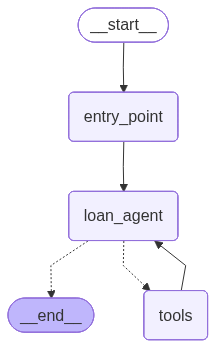

In [15]:

loan_graph = workflow.compile(checkpointer=checkpointer)

display(
    Image(
        loan_graph.get_graph().draw_mermaid_png()
    )
)

8. Invoke your Graph
Change the input and config and run execute it

In [16]:
customer_query = "I want to have $1000000"

In [17]:
inputs = {
    "customer_query": customer_query,
}

config = {
    "thread_id": 1,
    "customer_name": "Henrique Santana",
    "age": 34,
    "income": 1000,
    "credit_score": 750,
}

In [18]:
output = loan_graph.invoke(
    input=inputs,
    config=config,
)

Number of messages 1
I want to have $1000000
inside router status: in_progress
inside router status: in_progress
inside router status: lost


9. Inspect it
After executing, inspect the outputs

In [19]:
for message in output["messages"]:
    message.pretty_print()

================================ System Message ================================
Name: system

You are a Loan Agent analysing a customer loan request.
- Understand how much the customer needs.
- Calculate the maximum loan amount using one of the provided tools.
- If the requested amount exceeds the limit, update the negotiation to lost.
- If the requested amount meets the limit, update the negotiation to won.
- Update status as won or lost based on the negotiation.
Terminate gracefully:
  - If won: Notify that a human representative will contact them.
  - If lost: Thank the customer for their time and explain why the loan was refused.

Details about the customer you're negotiating with:
- customer_name: Henrique Santana- customer_age: 34- customer_income: 1000- customer_credit_score: 750
================================ Human Message =================================
Name: henrique_santana

I want to have $1000000
================================== Ai Message ==========================

In [20]:
output["negotiation_status"]

'lost'

In [21]:
state_history = list(
    loan_graph.get_state_history(
        config={
            "configurable":{"thread_id":1}
        }
    )
)

In [22]:
state_history

[StateSnapshot(values={'messages': [SystemMessage(content="You are a Loan Agent analysing a customer loan request.\n- Understand how much the customer needs.\n- Calculate the maximum loan amount using one of the provided tools.\n- If the requested amount exceeds the limit, update the negotiation to lost.\n- If the requested amount meets the limit, update the negotiation to won.\n- Update status as won or lost based on the negotiation.\nTerminate gracefully:\n  - If won: Notify that a human representative will contact them.\n  - If lost: Thank the customer for their time and explain why the loan was refused.\n\nDetails about the customer you're negotiating with:\n- customer_name: Henrique Santana- customer_age: 34- customer_income: 1000- customer_credit_score: 750", additional_kwargs={}, response_metadata={}, name='system', id='789344a1-688f-4565-8291-a500be6dc9c6'), HumanMessage(content='I want to have $1000000', additional_kwargs={}, response_metadata={}, name='henrique_santana', id='

In [23]:
state_history[0].values["messages"][-1].content

'Thank you for your time, Henrique. Unfortunately, your loan request for $1,000,000 exceeds the maximum amount we can offer, which is $10,000. If you have any other questions or need assistance, feel free to reach out.'

In [24]:
for m in state_history[0].values["messages"]:
    m.pretty_print()

================================ System Message ================================
Name: system

You are a Loan Agent analysing a customer loan request.
- Understand how much the customer needs.
- Calculate the maximum loan amount using one of the provided tools.
- If the requested amount exceeds the limit, update the negotiation to lost.
- If the requested amount meets the limit, update the negotiation to won.
- Update status as won or lost based on the negotiation.
Terminate gracefully:
  - If won: Notify that a human representative will contact them.
  - If lost: Thank the customer for their time and explain why the loan was refused.

Details about the customer you're negotiating with:
- customer_name: Henrique Santana- customer_age: 34- customer_income: 1000- customer_credit_score: 750
================================ Human Message =================================
Name: henrique_santana

I want to have $1000000
================================== Ai Message ==========================

10. Experiment
Now that you understood how it works, experiment with new things.

Run multiple times for the same thread_id, whant happens with the messages?
Add a tool to calculate interests and taxes to enable pay in installments
Improve negotiation, allowing the agent to offer discounts to close the deal